In [1]:

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [4]:
from google.colab import files # 데이터 불러오기
# file_uploaded=files.upload()

!unzip catdog.zip -d catdog/

cat_directory = 'catdog/train/cat/'
dog_directory = 'catdog/train/dog/'

Archive:  catdog.zip
   creating: catdog/test/
   creating: catdog/test/cat/
  inflating: catdog/test/cat/cat.801.jpg  
  inflating: catdog/test/cat/cat.802.jpg  
  inflating: catdog/test/cat/cat.803.jpg  
  inflating: catdog/test/cat/cat.804.jpg  
  inflating: catdog/test/cat/cat.805.jpg  
  inflating: catdog/test/cat/cat.806.jpg  
  inflating: catdog/test/cat/cat.807.jpg  
  inflating: catdog/test/cat/cat.808.jpg  
  inflating: catdog/test/cat/cat.809.jpg  
  inflating: catdog/test/cat/cat.810.jpg  
   creating: catdog/test/dog/
  inflating: catdog/test/dog/dog.800.jpg  
  inflating: catdog/test/dog/dog.801.jpg  
  inflating: catdog/test/dog/dog.802.jpg  
  inflating: catdog/test/dog/dog.803.jpg  
  inflating: catdog/test/dog/dog.804.jpg  
  inflating: catdog/test/dog/dog.805.jpg  
  inflating: catdog/test/dog/dog.806.jpg  
  inflating: catdog/test/dog/dog.807.jpg  
  inflating: catdog/test/dog/dog.808.jpg  
  inflating: catdog/test/dog/dog.809.jpg  
  inflating: catdog/test/dog/dog.

In [5]:
cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


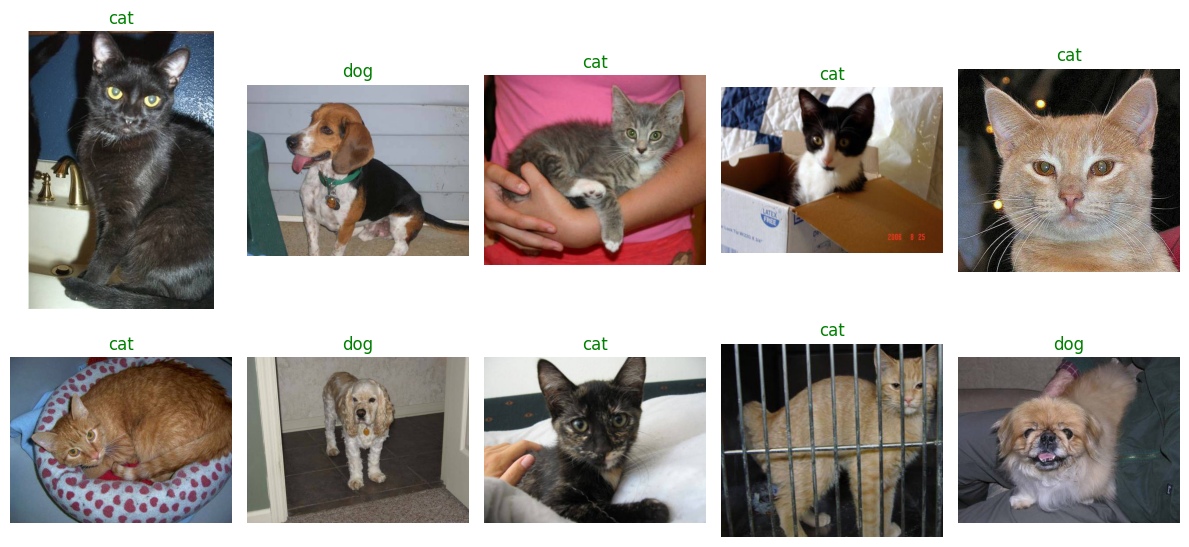

In [6]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        #D:/python_ai_day/data/catanddog/train/Cat/cat.jpg
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths)

In [7]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [14]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([3, 224, 224])
0
torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1])


In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [16]:
#torchsummary 라이브러리 설치할 것
#!pip install torchsummary

from torchsummary import summary
summary(model, input_size=(3, 224, 224))

#model.parameters 함수를 사용하여 전체 파라미터만 확인 가능한 함수
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [17]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-17-8630aa20a1e2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6940 Acc: 0.5350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6981 Acc: 0.5000
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6858 Acc: 0.5725


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7071 Acc: 0.4674
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6879 Acc: 0.5625


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7130 Acc: 0.4891
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6788 Acc: 0.5575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7024 Acc: 0.5435
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6726 Acc: 0.5900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6962 Acc: 0.5652
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6640 Acc: 0.6500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5543
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6656 Acc: 0.5900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6915 Acc: 0.5870
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6589 Acc: 0.6025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6876 Acc: 0.5652
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6530 Acc: 0.6350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6848 Acc: 0.5543
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6501 Acc: 0.6350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6861 Acc: 0.5870
Training complete in 5m 23s
Best val Acc: 0.586957


In [18]:
import pandas as pd

id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('LesNet.csv', index=False)

<ipython-input-18-c58bc2d5b601>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
df = pd.read_csv('LesNet.csv')
df.head(10)

,id,label
0,109,0.467511
1,145,0.389408
2,15,0.538244
3,162,0.419821
4,167,0.559536
5,200,0.427021
6,210,0.644821
7,211,0.618037
8,213,0.416666
9,224,0.648736


#### 예측 결과 시각화

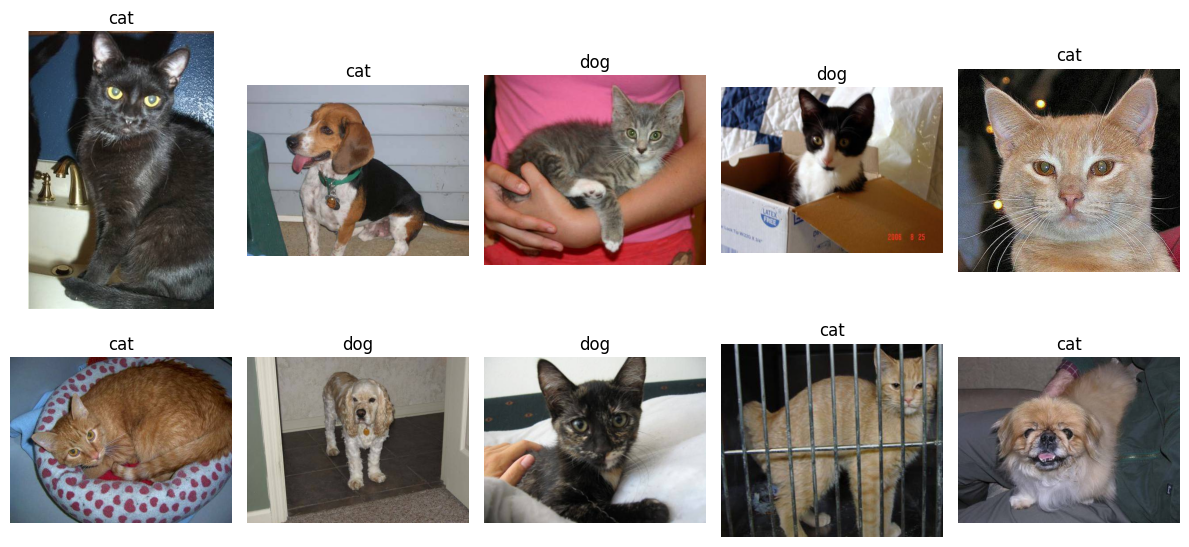

In [23]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths)